In [1]:
from google.colab import files, drive
drive.mount('/content/drive')

Mounted at /content/drive


#Install, import and setup files
1.   Install DDSP
2.   Import Python libraries
3.   Configure folders
4.   Copy instruments and examples to Colab

In [2]:
%tensorflow_version 2.x
!pip install -qU ddsp

     |████████████████████████████████| 153kB 14.4MB/s 
     |████████████████████████████████| 3.7MB 27.3MB/s 
     |████████████████████████████████| 92kB 12.5MB/s 
     |████████████████████████████████| 368kB 50.6MB/s 


In [3]:
import warnings
import copy
import os
import time
import glob
import gin
import librosa
import pickle
import crepe
import ddsp
import ddsp.training

import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import ipywidgets as widgets

from ddsp.colab import colab_utils
from ddsp.colab.colab_utils import (
    auto_tune, detect_notes, fit_quantile_transform, 
    get_tuning_factor, download, play, record, audio_bytes_to_np,
    specplot, upload, DEFAULT_SAMPLE_RATE)
from google.colab import files
from ipywidgets import interact


sample_rate = DEFAULT_SAMPLE_RATE  # 16000


#Use retina mode
%config InlineBackend.figure_format='retina'

#Ignore warnings
warnings.filterwarnings("ignore")

#Set some globals
REALEXAMPLE = ''
REALINSTRUMENT = ''
audio = None
audio_features = None
ckpt = None
model = None
DATASET_STATS = None

TRIM = -15

In [4]:
DRIVE_DIR = '/content/drive/My Drive/SMC 09/DDSP' #@param {type: "string"}
INSTRUMENTS_FOLDER = 'instruments'
EXAMPLES_FOLDER = 'examples'

In [5]:
EXAMPLES_DIR = DRIVE_DIR + '/' + EXAMPLES_FOLDER
assert os.path.exists(EXAMPLES_DIR)
COLAB_EXAMPLES_DIR = 'data/examples' 
!mkdir -p $COLAB_EXAMPLES_DIR

mp3_files = glob.glob(os.path.join(EXAMPLES_DIR, '*.mp3'))
wav_files = glob.glob(os.path.join(EXAMPLES_DIR, '*.wav'))
audio_files = mp3_files + wav_files
example_file_list = [os.path.basename(file) for file in (audio_files)]
example_file_list.sort()

print("Copying {} examples".format(len(example_file_list)))
for fname in audio_files:
    target_name = os.path.join(COLAB_EXAMPLES_DIR, 
                               os.path.basename(fname).replace(' ', '_').replace('\'', '_'))
    #print('  {}'.format(target_name))
    !cp "$fname" $target_name


INSTRUMENTS_DIR = DRIVE_DIR + '/' + INSTRUMENTS_FOLDER
assert os.path.exists(INSTRUMENTS_DIR)
COLAB_INSTRUMENTS_DIR = 'data/instruments' 
!mkdir -p $COLAB_INSTRUMENTS_DIR

zip_files = glob.glob(os.path.join(INSTRUMENTS_DIR, '*.zip'))
instrument_file_list = [os.path.basename(file) for file in (zip_files)]
instrument_file_list.sort()

print("Copying {} instruments".format(len(instrument_file_list)))
for fname in zip_files:
    target_name = os.path.join(COLAB_INSTRUMENTS_DIR, 
                               os.path.basename(fname).replace(' ', '_').replace('\'', '_'))
    #print('  {}'.format(target_name))
    !cp "$fname" $target_name


Copying 20 examples
Copying 9 instruments


# Helper functions

In [6]:
def load_example(example_name):

  global REALEXAMPLE, audio, audio_features

  if (REALEXAMPLE!=example_name):
    print('Loading audio and extracting features...')
    REALEXAMPLE=example_name
    start_time = time.time()

    with open(COLAB_EXAMPLES_DIR+'/'+REALEXAMPLE, 'rb') as fd:
      contents = fd.read()

    audio = audio_bytes_to_np(contents, sample_rate=DEFAULT_SAMPLE_RATE, normalize_db=None)
    audio = audio[np.newaxis, :]

    #Compute features.
    ddsp.spectral_ops.reset_crepe()
    audio_features = ddsp.training.metrics.compute_audio_features(audio)
    audio_features['loudness_db'] = audio_features['loudness_db'].astype(np.float32)
    print('Operation took %.1f seconds' % (time.time() - start_time))

    #fig, ax = plt.subplots(nrows=3, 
    #                   ncols=1, 
    #                   sharex=True,
    #                   figsize=(12, 8))
    #ax[0].plot(audio_features['loudness_db'][:TRIM])
    #ax[0].set_ylabel('loudness_db')

    #ax[1].plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
    #ax[1].set_ylabel('f0 [midi]')

    #ax[2].plot(audio_features['f0_confidence'][:TRIM])
    #ax[2].set_ylabel('f0 confidence')
    #_ = ax[2].set_xlabel('Time step [frame]')

    if REALEXAMPLE != '' and REALINSTRUMENT != '':
      print("Restoring model from load_example")
      restore_model()


In [7]:
def load_instrument(instrument_name):

  global REALINSTRUMENT, model, ckpt, DATASET_STATS

  if (REALINSTRUMENT!=instrument_name):
    print('Loading the model...')
    REALINSTRUMENT=instrument_name
    start_time = time.time()
    
    COLAB_MODEL_DIR = COLAB_INSTRUMENTS_DIR + '/current'
    print(f'Unziping {instrument_name}')
    !rm -r $COLAB_MODEL_DIR
    !unzip -j $COLAB_INSTRUMENTS_DIR'/'$instrument_name -d $COLAB_MODEL_DIR &> /dev/null
  
    #gin file
    gin_file = os.path.join(COLAB_MODEL_DIR, 'operative_config-0.gin')
    with gin.unlock_config():
      gin.parse_config_file(gin_file, skip_unknown=True)

    #stats
    dataset_stats_file = os.path.join(COLAB_MODEL_DIR, 'dataset_statistics.pkl')
    print(f'Loading dataset statistics from {dataset_stats_file}')
    try:
      if tf.io.gfile.exists(dataset_stats_file):
        with tf.io.gfile.GFile(dataset_stats_file, 'rb') as f:
          DATASET_STATS = pickle.load(f)
      else:
          print('WARNING: pickle file not present')
          DATASET_STATS = None
    except Exception as err:
      print('Loading dataset statistics from pickle failed: {}.'.format(err))
  
    #checkpoints
    ckpt_files = [f for f in tf.io.gfile.listdir(COLAB_MODEL_DIR) if 'ckpt' in f]
    ckpt_name = ckpt_files[0].split('.')[0]
    ckpt = os.path.join(COLAB_MODEL_DIR, ckpt_name)
    print('Restoring checkpoint %s took %.1f seconds' % (ckpt_name, time.time() - start_time))

    if REALEXAMPLE != '' and REALINSTRUMENT != '':
      print("Restoring model from load_instrument")
      restore_model()

In [8]:
def shift_loudness(audio_features, ld_shift=0.0):
  #Shift loudness by a number of dB
  audio_features['loudness_db'] += ld_shift
  return audio_features


def shift_f0(audio_features, octave_shift=0.0):
  #Shift f0 by a number of octaves
  audio_features['f0_hz'] *= 2.0 ** (octave_shift)
  audio_features['f0_hz'] = np.clip(audio_features['f0_hz'], 
                                    0.0, 
                                    librosa.midi_to_hz(110.0))
  return audio_features

In [9]:
def restore_model():
  global model, audio_features, ckpt

  #Ensure dimensions and sampling rates are equal
  time_steps_train = gin.query_parameter('DefaultPreprocessor.time_steps')
  n_samples_train = gin.query_parameter('Additive.n_samples')
  hop_size = int(n_samples_train / time_steps_train)

  time_steps = int(audio.shape[1] / hop_size)
  n_samples = time_steps * hop_size

  gin_params = [
      'Additive.n_samples = {}'.format(n_samples),
      'FilteredNoise.n_samples = {}'.format(n_samples),
      'DefaultPreprocessor.time_steps = {}'.format(time_steps),
      'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
  ]

  with gin.unlock_config():
    gin.parse_config(gin_params)

  # Trim all input vectors to correct lengths 
  for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
      audio_features[key] = audio_features[key][:time_steps]
  audio_features['audio'] = audio_features['audio'][:, :n_samples]

  #Set up the model just to predict audio given new conditioning
  model = ddsp.training.models.Autoencoder()
  model.restore(ckpt)

#Set instrument and example

In [10]:
instrument_widget = widgets.Dropdown(options = instrument_file_list, value=instrument_file_list[2])
interact(load_instrument, instrument_name=instrument_widget);

example_widget = widgets.Dropdown(options = example_file_list, value=example_file_list[13])
interact(load_example, example_name=example_widget);

interactive(children=(Dropdown(description='instrument_name', index=2, options=('alba_40k_instrument.zip', 'be…

interactive(children=(Dropdown(description='example_name', index=13, options=('instr_cello.mp3', 'instr_family…

#Preprocess example

In [17]:
#Improve loudness with statistical info
use_norm = True
mask_threshold = 1
quiet = 45

#Improve pitch
autotune_amount = 0

#Adjust source material to model pitch and loudness
octave_shift = 2
loudness_shift = 0



audio_features_mod = {k: v.copy() for k, v in audio_features.items()}

mask_on, note_on_ratio = detect_notes(audio_features['loudness_db'],
                                      audio_features['f0_confidence'],
                                      mask_threshold, 
                                      exponent=2.0)

if DATASET_STATS is not None:
  _, loudness_norm = fit_quantile_transform(audio_features['loudness_db'],
                                            mask_on,
                                            inv_quantile=DATASET_STATS['quantile_transform'])

  mask_off = np.logical_not(mask_on)
  loudness_norm[mask_off] -=  quiet * (1.0 - note_on_ratio[mask_off][:, np.newaxis])
  loudness_norm = np.reshape(loudness_norm, audio_features['loudness_db'].shape) 
  if use_norm:
    audio_features_mod['loudness_db'] = loudness_norm 


if autotune_amount > 0:
  f0_midi = np.array(ddsp.core.hz_to_midi(audio_features_mod['f0_hz']))
  tuning_factor = get_tuning_factor(f0_midi, audio_features_mod['f0_confidence'], mask_on)
  f0_midi_at = auto_tune(f0_midi, tuning_factor, mask_on, amount=autotune_amount, chromatic=True)
  audio_features_mod['f0_hz'] = ddsp.core.midi_to_hz(f0_midi_at)

audio_features_mod = shift_loudness(audio_features_mod, loudness_shift)
audio_features_mod = shift_f0(audio_features_mod, octave_shift)

#Run the model

EXAMPLE = 'song_rainbow.mp3'
INSTRUMENT = 'violin_instrument.zip
octave_shift = 2.00
loudness_shift = 0
mask_threshold = 1.00
quiet = 45
autotune_amount = 0.00

Prediction took 1.1 seconds
Original


Resynthesis


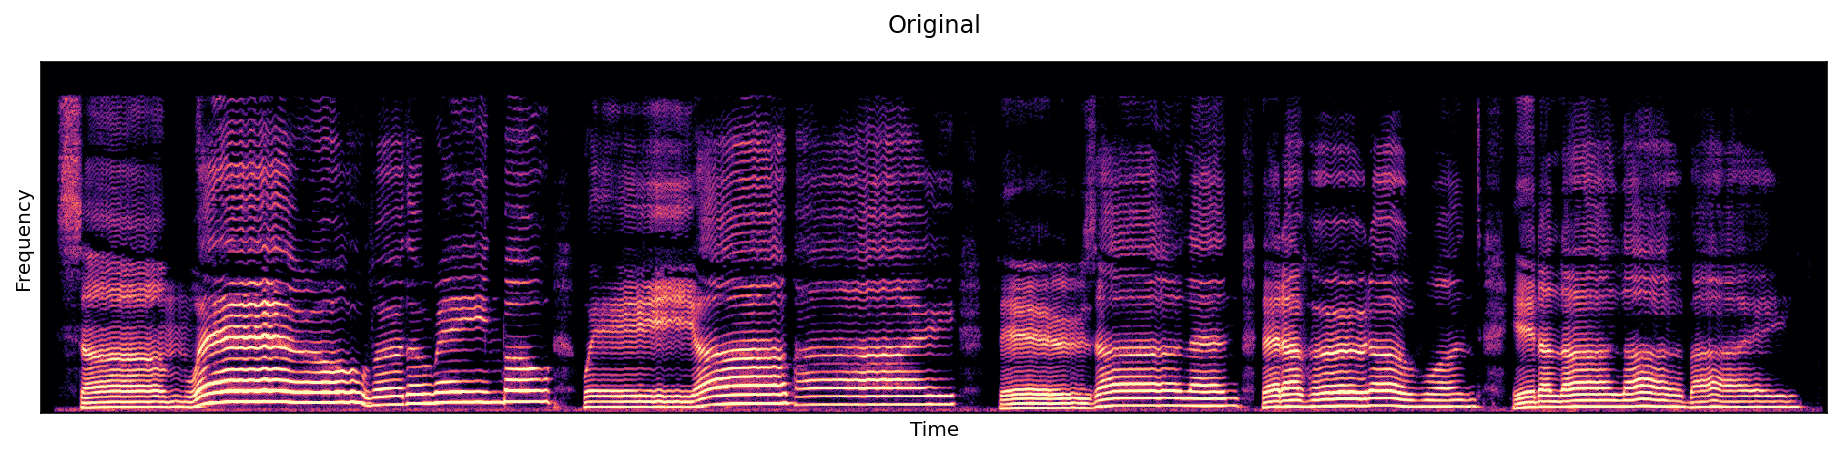

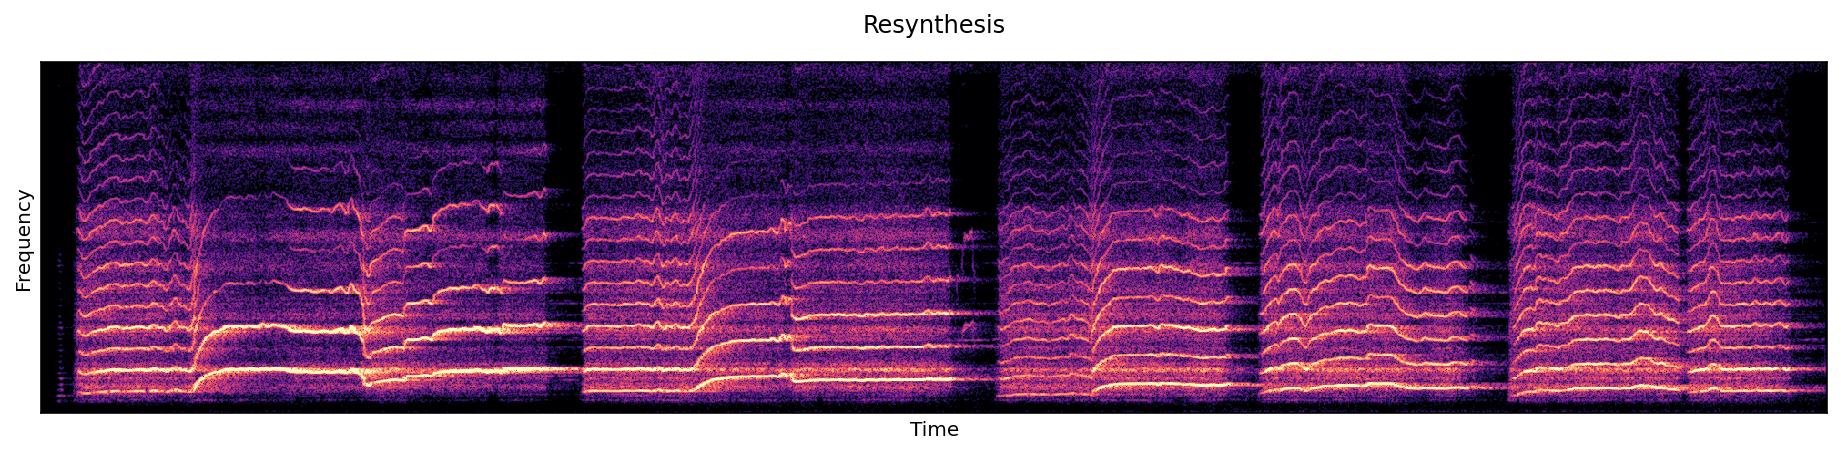

In [18]:
print("EXAMPLE = '%s'" % REALEXAMPLE)
print("INSTRUMENT = '%s" % REALINSTRUMENT)
print('octave_shift = %.2f' % octave_shift)
print('loudness_shift = %d' % loudness_shift)
print('mask_threshold = %.2f' % mask_threshold)
print('quiet = %d' % quiet)
print('autotune_amount = %.2f' % autotune_amount)
print()

# Run a batch of predictions.
start_time = time.time()

outputs = model(audio_features_mod, training=False)
audio_gen = model.get_audio_from_outputs(outputs)

#Old code for DDSP v0.13.0
#controls =  model.get_controls(audio_features_mod, training=False)
#audio_gen = controls['processor_group']['signal']

print('Prediction took %.1f seconds' % (time.time() - start_time))

# Plot
print('Original')
play(audio)

print('Resynthesis')
play(audio_gen)


specplot(audio)
plt.title("Original")

specplot(audio_gen)
_ = plt.title("Resynthesis")


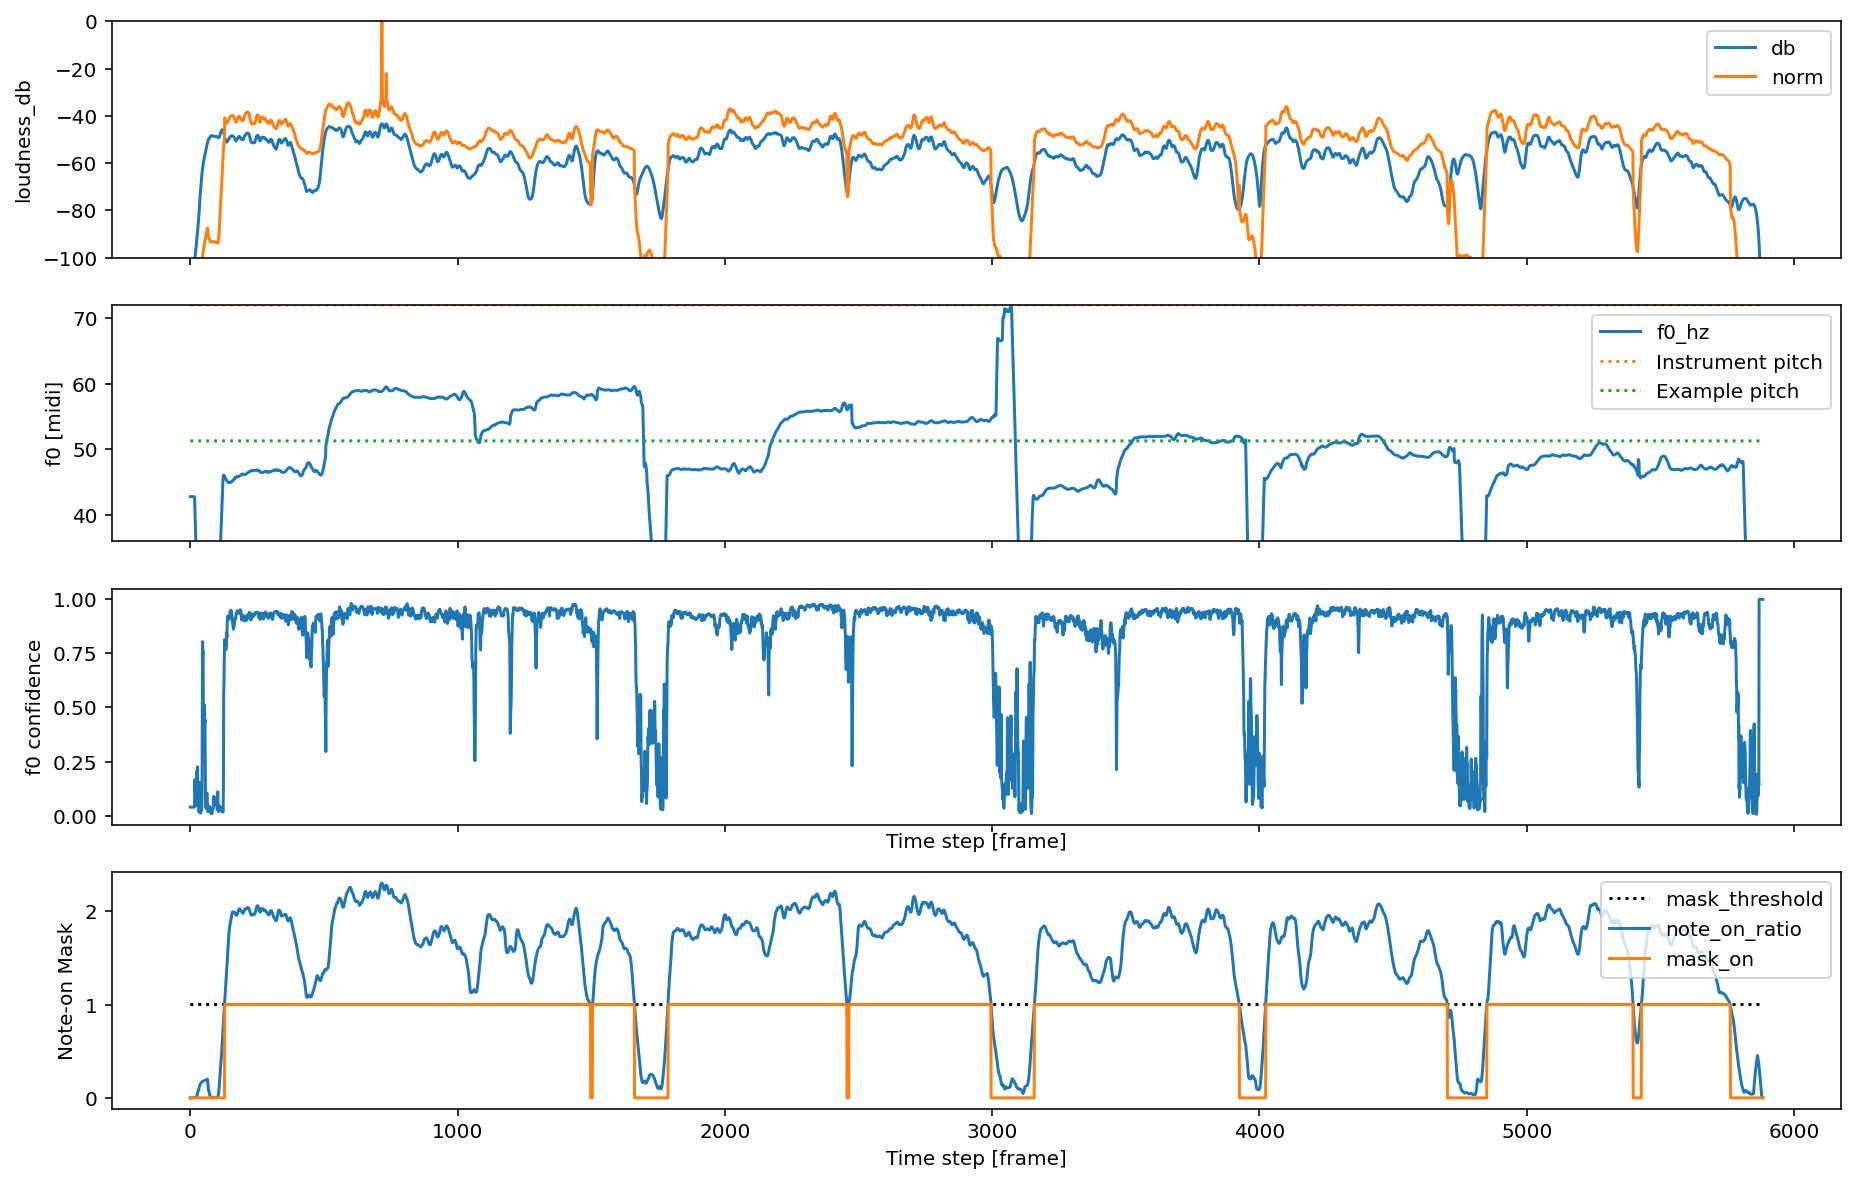

In [19]:
#auto octave adjustment.
instrument_mean_pitch = DATASET_STATS['mean_pitch']
pitch = ddsp.core.hz_to_midi(audio_features['f0_hz'])
example_mean_pitch = np.mean(pitch[mask_on])

#p_diff = instrument_mean_pitch - example_mean_pitch
#p_diff_octave = p_diff / 12.0
#round_fn = np.floor if p_diff_octave > 1.5 else np.ceil
#p_diff_octave = round_fn(p_diff_octave)
#audio_features_mod = shift_f0(audio_features_mod, p_diff_octave)




fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(15.5, 10))
ax[0].plot(audio_features['loudness_db'])
ax[0].plot(loudness_norm)
ax[0].legend(['db', 'norm'])
ax[0].set_ylabel('loudness_db')
ax[0].set_ylim(-100,0)
ax[1].plot(librosa.hz_to_midi(audio_features['f0_hz']))
ax[1].plot(np.ones_like(mask_on) * instrument_mean_pitch, ':')
ax[1].plot(np.ones_like(mask_on) * example_mean_pitch, ':')
if autotune_amount > 0:
  ax[1].plot(f0_midi_at)
  ax[1].legend(['f0_hz', 'Instrument pitch','Example pitch', 'autotune'])
else:
  ax[1].legend(['f0_hz', 'Instrument pitch','Example pitch'])
ax[1].set_ylabel('f0 [midi]')
ax[1].set_ylim(36,72)
ax[2].plot(audio_features['f0_confidence'])
ax[2].set_ylabel('f0 confidence')
ax[2].set_xlabel('Time step [frame]')
ax[3].plot(np.ones_like(mask_on) * mask_threshold, 'k:')
ax[3].plot(note_on_ratio)
ax[3].plot(mask_on)
ax[3].set_ylabel('Note-on Mask')
ax[3].legend(['mask_threshold', 'note_on_ratio', 'mask_on'])
_=ax[3].set_xlabel('Time step [frame]')
